In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
from scipy.stats import iqr

def kde_nd(x, y, weight=None, stats=False):
    '''Kernel density estimator
    
    ...
    
    Arguments
    ---------
    x : list of ndarrays
        Measured data points
        
    y : list of ndarrays
        Points at which the density should be estimated
        
    Keywords
    --------
    weight: ndarray
        Value at each of the measured data points.
        Default: 1.
        
    stats: bool
        Return statistical information, if True
        
    Returns
    -------
    rho: ndarray
        Density at each of the sampling points, optionally weighted
        by the specified values
    scale: ndarray | optional
        Scale factors for each of the dimensions in the list of
        measured data points.
    sigma: ndarray | optional
        Variance of the returned value at each sampling point.
    '''
    nd = len(x)     # number of dimensions
    nx = x[0].size  # number of data points
    ny = y[0].size  # number of sample points
    
    # optimal smoothing parameter in each dimension
    # Silverman Eqs. (3.30) and (3.31)
    sx = [this.std() for this in x]
    rx = [iqr(this) for this in x]
    h = np.array(sx)
    for n in range(nd):
        if (rx[n] > 1e-10):
            h[n] = np.min([sx[n], rx[n]/1.34])
        h[n] *= 0.9/nx**0.2
    
    # density estimate
    # Silverman Eq. (2.15) and Table 3.1
    t = np.array([this/h[n] for n, this in enumerate(x)]).T
    s = np.array([this/h[n] for n, this in enumerate(y)]).T

    if weight is None:
        weight = np.ones(nx)
    normalization = weight * np.prod((2.*np.pi*h**2)**(-0.5))/nx
    
    rho = np.empty(ny)
    sigma = np.empty(ny)
    for n in range(ny):
        z = 0.5 * np.sum((t - s[n,:])**2, axis=1)
        value = normalization * np.exp(-z)
        rho[n] = np.sum(value)
        sigma[n] = np.sum(value**2)
    if stats:
        return rho, h, sigma
    return rho

In [4]:
def akde_nd(x, y, weight=None, alpha=0.5):
    nd = len(x)     # number of dimensions
    nx = x[0].size  # number of data points
    ny = y[0].size  # number of sample points
    
    # Method described by Silverman Sec. 5.3.1
    # 1. pilot estimate of the density at the data points
    rho, scale, sigma = kde_nd(x, x, stats=True)
    
    # 2. local bandwidth factor
    g = np.exp(np.mean(np.log(rho))) # geometric mean density
    factor = (g/rho)**alpha          # Eq. (5.7)
    h = np.outer(factor, scale)      # Scale for each input point
    
    # 3. adaptive density estimate
    if weight is None:
        weight = np.ones(nx)
    normalization = weight * (2.*np.pi * np.sum(h**2, axis=1))**(-nd/2.) / nx

    t = np.array(x).T
    s = np.array(y).T
    rho = np.empty(ny)
    for n in range(ny):
        z = 0.5 * np.sum(((t - s[n,:])/h)**2, axis=1)
        value = normalization * np.exp(-z)
        rho[n] = np.sum(value)
    return rho

In [5]:
def distribution(data, value, nx=100, ny=100):
    x = np.linspace(min(data[0]), max(data[0]), nx)
    y = np.linspace(min(data[1]), max(data[1]), ny)
    xx, yy = np.meshgrid(x, y)
    sample = [xx.ravel(), yy.ravel()]
    rhow = akde_nd(data, sample, value)
    rho = akde_nd(data, sample)
    return (rhow/rho).reshape(nx, ny), xx, yy

In [6]:
df = pd.read_csv('data/NDR_table_predicted_peaks_and_valleys02.csv')
df

,Vgg,RL,V_peak,I_peak,V_valley,I_valley
0,2.0,10000.0,0.69,0.000139,1.07,0.000128
1,2.0,18000.0,0.62,0.000110,1.23,0.000077
2,2.0,26000.0,0.59,0.000100,1.30,0.000056
3,2.0,34000.0,0.58,0.000094,1.35,0.000044
4,2.0,42000.0,0.58,0.000091,1.38,0.000036
...,...,...,...,...,...,...
91,5.0,18000.0,1.41,0.001424,4.62,0.000281
92,5.0,26000.0,1.39,0.001400,4.80,0.000201
93,5.0,34000.0,1.39,0.001388,4.92,0.000157
94,5.0,42000.0,1.38,0.001380,5.02,0.000129


In [7]:
Vpeak, Vgg, RL = distribution([df.Vgg, df.RL], df.V_peak)

Ipeak, Vgg, RL = distribution([df.Vgg, df.RL], df.I_peak)

Vval, Vgg, RL = distribution([df.Vgg, df.RL], df.V_valley)

Ival, Vgg, RL = distribution([df.Vgg, df.RL], df.I_valley)

Ipeak*=1e3
Ival*=1e3
RL*=1e-3

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_59963/2917021446.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


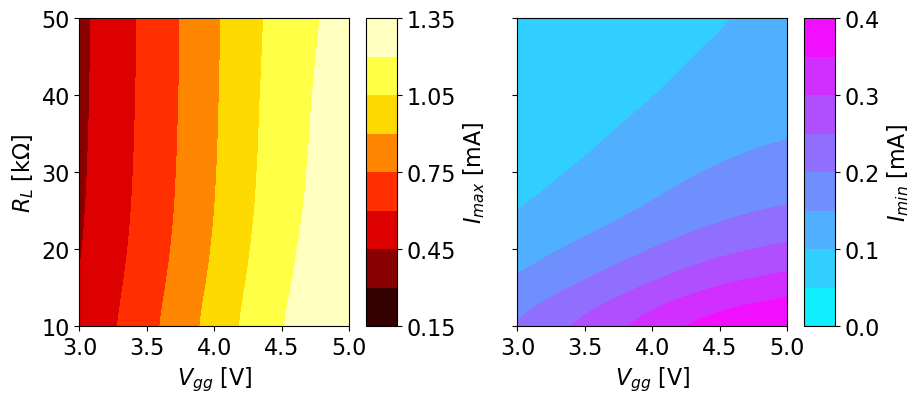

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True, gridspec_kw={'wspace':0.3})

cb1 = ax1.contourf(Vgg, RL, Ipeak, cmap='hot')
cb2 = ax2.contourf(Vgg, RL, Ival, cmap='cool')

ax1.set_xlim(3, 5)
ax1.set_ylim(10, 50)
ax1.set_xlabel(r'$V_{gg}$ [V]')
ax2.set_xlabel(r'$V_{gg}$ [V]')
ax1.set_ylabel(r'$R_L$ [k$\Omega$]')

fig.colorbar(cb1, label=r'$I_{max}$ [mA]', 
             ticks=[0.15, 0.45, 0.75, 1.05, 1.35], 
             shrink=1, aspect=10)
fig.colorbar(cb2, label=r'$I_{min}$ [mA]', 
             ticks=[0, 0.1, 0.2, 0.3, 0.4],
             shrink=1, aspect=10)
fig.tight_layout()
fig.savefig('figures/spice_model_parameterize_IVcurve02.png', bbox_inches = "tight", dpi=600)

In [9]:
exp_df = pd.read_csv('data/exp_param_IVcurve_peakvalley.csv')

In [10]:
exp_df2 = exp_df.dropna()

In [11]:
Vpeak, Vgg, RL = distribution([exp_df2.Vgg, exp_df2.RL], exp_df2.Vmax)

Ipeak, Vgg, RL = distribution([exp_df2.Vgg, exp_df2.RL], exp_df2.Imax)

Vval, Vgg, RL = distribution([exp_df2.Vgg, exp_df2.RL], exp_df2.Vmin)

Ival, Vgg, RL = distribution([exp_df2.Vgg, exp_df2.RL], exp_df2.Imin)

Ipeak*=1e3
Ival*=1e3
RL*=1e-3

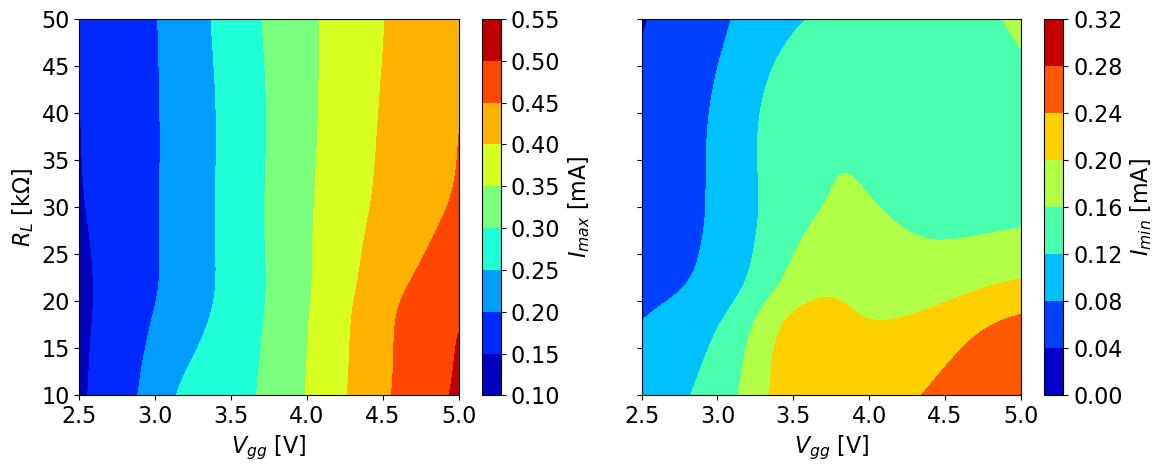

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

cb1 = ax1.contourf(Vgg, RL, Ipeak, cmap='jet')
cb2 = ax2.contourf(Vgg, RL, Ival, cmap='jet')

ax1.set_xlim(2.5, 5)
ax1.set_ylim(10, 50)
ax1.set_xlabel(r'$V_{gg}$ [V]')
ax2.set_xlabel(r'$V_{gg}$ [V]')
ax1.set_ylabel(r'$R_L$ [k$\Omega$]')

fig.colorbar(cb1, label=r'$I_{max}$ [mA]')
fig.colorbar(cb2, label=r'$I_{min}$ [mA]')
fig.tight_layout()

# fig.savefig('figures/exp_data_parameterize_IVcurve.png')

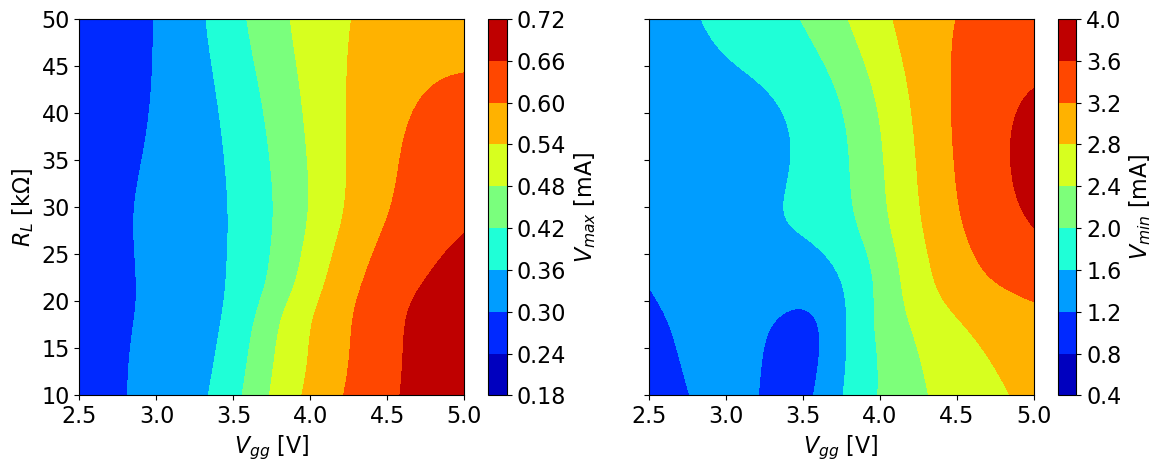

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

cb1 = ax1.contourf(Vgg, RL, Vpeak, cmap='jet') #cmap='hot')
cb2 = ax2.contourf(Vgg, RL, Vval, cmap='jet')#cmap='cool')

ax1.set_xlim(2.5, 5)
ax1.set_ylim(10, 50)
ax1.set_xlabel(r'$V_{gg}$ [V]')
ax2.set_xlabel(r'$V_{gg}$ [V]')
ax1.set_ylabel(r'$R_L$ [k$\Omega$]')

fig.colorbar(cb1, label=r'$V_{max}$ [mA]')
fig.colorbar(cb2, label=r'$V_{min}$ [mA]')
fig.tight_layout()

# fig.savefig('figures/exp_data_parameterize_IVcurve.png')

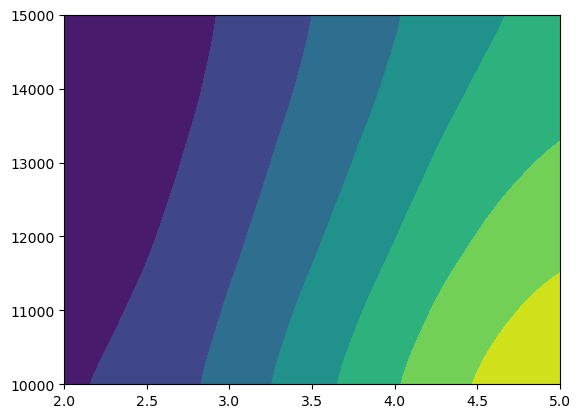

In [25]:
fig, ax = plt.subplots()

ax.contourf(Vgg, RL, Ival)